In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("✅ Libraries loaded!")

✅ Libraries loaded!


## Load Enhanced Dataset

In [2]:
# Load the feature-engineered dataset
df = pd.read_csv('../data/processed/fiscal_data_enhanced.csv')

print(f"Dataset loaded: {df.shape}")
print(f"Countries: {df['Country'].nunique()}")
print(f"Year range: {df['Year'].min():.0f} - {df['Year'].max():.0f}")
print(f"\nTotal features: {len(df.columns)}")
print(f"\nMissing values: {df.isnull().sum().sum()}")

# Show sample
df.head()

Dataset loaded: (623, 50)
Countries: 14
Year range: 1960 - 2025

Total features: 50

Missing values: 84


,Country,Country Code,Year,Budget Deficit/Surplus,Capital Expenditure,Consumer Price Index (CPI),Defence Expenditure,Education Expenditure,Expenditure,Exports,Food Inflation,Food Inflation YoY,GDP Growth Rate,GDP per Capita,GDP per capita,Government Debt,Health Expenditure,Imports,Inflation Rate,Interest Rate,Labour Force,Nominal GDP,Population,Real GDP,Revenue,Tax Revenue,Unemployment Rate,Value Added Tax (VAT),Health_Expenditure_Per_Capita,Education_Expenditure_Per_Capita,Capital_Expenditure_Per_Capita,Revenue_Per_Capita,Tax_Revenue_Per_Capita,Debt_to_GDP_Ratio,Tax_to_GDP_Ratio,Health_Spending_to_GDP,Education_Spending_to_GDP,Budget_Balance_to_GDP,Trade_Balance,Trade_Openness,Revenue_Growth_Rate,Tax_Revenue_Growth_Rate,Health_Expenditure_Growth_Rate,Population_Growth_Rate,Debt_Growth_Rate,Fiscal_Capacity_Index,Social_Spending_Ratio,Infrastructure_Investment_Ratio,Export_Intensity,Inflation_Volatility
0,Algeria,DZA,1977.00,-427.40,2611.30,101.43,6085.00,11701.00,2894.92,6.00,5.62,7.02,5.40,2453.16,70163.00,22276.20,8585.00,-6.21,5.20,10.00,18560025.00,1835042.80,18970215.00,25122.16,2955.58,2330.95,17.46,197008.58,0.00,0.00,0.00,0.00,0.00,1.21,0.13,0.47,0.64,-0.02,12.21,-0.00,NaN,NaN,NaN,NaN,NaN,78.87,700.74,0.14,0.00,NaN
1,Algeria,DZA,1978.00,-427.40,2611.30,101.43,6085.00,11701.00,2894.92,6.30,5.62,7.02,5.40,2453.16,70163.00,22276.20,8585.00,-7.32,5.20,10.00,18560025.00,1835042.80,18970215.00,25122.16,2955.58,2330.95,17.46,197008.58,0.00,0.00,0.00,0.00,0.00,1.21,0.13,0.47,0.64,-0.02,13.62,-0.00,0.00,0.00,0.00,0.00,0.00,78.87,700.74,0.14,0.00,0.00
2,Algeria,DZA,1979.00,-427.40,2611.30,101.43,6085.00,11701.00,2894.92,9.50,5.62,7.02,5.40,2453.16,70163.00,22276.20,8585.00,-7.82,5.20,10.00,18560025.00,1835042.80,18970215.00,25122.16,2955.58,2330.95,17.46,197008.58,0.00,0.00,0.00,0.00,0.00,1.21,0.13,0.47,0.64,-0.02,17.32,0.00,0.00,0.00,0.00,0.00,0.00,78.87,700.74,0.14,0.00,0.00
3,Algeria,DZA,1980.00,-427.40,2611.30,101.43,6085.00,11701.00,2894.92,13.70,5.62,7.02,5.40,2453.16,70163.00,22276.20,8585.00,-9.61,5.20,10.00,18560025.00,1835042.80,18970215.00,25122.16,2955.58,2330.95,17.46,197008.58,0.00,0.00,0.00,0.00,0.00,1.21,0.13,0.47,0.64,-0.02,23.31,0.00,0.00,0.00,0.00,0.00,0.00,78.87,700.74,0.14,0.00,0.00
4,Algeria,DZA,1981.00,-427.40,2611.30,101.43,6085.00,11701.00,2894.92,14.10,5.62,7.02,5.40,2453.16,70163.00,22276.20,8585.00,-10.11,5.20,10.00,18560025.00,1835042.80,18970215.00,25122.16,2955.58,2330.95,17.46,197008.58,0.00,0.00,0.00,0.00,0.00,1.21,0.13,0.47,0.64,-0.02,24.21,0.00,0.00,0.00,0.00,0.00,0.00,78.87,700.74,0.14,0.00,0.00


## Step 1: SDG Key Metrics Overview

In [3]:
# Define our SDG-aligned metrics for analysis
sdg_metrics = {
    'SDG 8 (Economic Growth)': [
        'GDP Growth Rate',
        'Tax_to_GDP_Ratio',
        'Revenue_Growth_Rate',
        'Tax_Revenue_Growth_Rate',
        'Unemployment Rate',
        'Trade_Balance'
    ],
    'SDG 16 (Governance)': [
        'Tax_to_GDP_Ratio',
        'Fiscal_Capacity_Index',
        'Inflation_Volatility',
        'Inflation Rate'
    ],
    'SDG 9 (Infrastructure)': [
        'Debt_to_GDP_Ratio',
        'Infrastructure_Investment_Ratio',
        'Capital_Expenditure_Per_Capita',
        'Debt_Growth_Rate'
    ],
    'SDG 3 (Health)': [
        'Health_Expenditure_Per_Capita',
        'Health_Spending_to_GDP',
        'Health_Expenditure_Growth_Rate'
    ],
    'SDG 1 (Poverty)': [
        'GDP per Capita',
        'Real GDP',
        'Revenue_Per_Capita'
    ]
}

# Get all unique metrics
all_metrics = []
for metrics in sdg_metrics.values():
    all_metrics.extend(metrics)
all_metrics = list(set(all_metrics))

# Check which metrics exist in our dataset
available_metrics = [m for m in all_metrics if m in df.columns]
missing_metrics = [m for m in all_metrics if m not in df.columns]

print(f"Available metrics: {len(available_metrics)}/{len(all_metrics)}")
if missing_metrics:
    print(f"\n⚠️ Missing metrics: {missing_metrics}")

# Summary statistics for key metrics
print("\n" + "="*70)
print("KEY METRICS SUMMARY STATISTICS")
print("="*70)

key_cols = ['GDP Growth Rate', 'Tax_to_GDP_Ratio', 'Debt_to_GDP_Ratio', 
            'Health_Expenditure_Per_Capita', 'Inflation Rate']
key_cols = [c for c in key_cols if c in df.columns]

if key_cols:
    print(df[key_cols].describe())

Available metrics: 19/19

KEY METRICS SUMMARY STATISTICS
       GDP Growth Rate  Tax_to_GDP_Ratio  Debt_to_GDP_Ratio  \
count           623.00            623.00             623.00   
mean              4.00           2167.51          179201.05   
std               3.31          10596.05         1316476.23   
min             -15.73              0.00               0.03   
25%               2.71              6.09               2.96   
50%               4.39             13.92              96.44   
75%               5.79             28.88             314.48   
max              15.33         134511.11        14517262.48   

       Health_Expenditure_Per_Capita  Inflation Rate  
count                         623.00          623.00  
mean                            0.00            7.86  
std                             0.00            5.81  
min                             0.00           -0.93  
25%                             0.00            4.61  
50%                             0.00         

## Step 2: Correlation Analysis - The "Efficiency Gap" Test

In [4]:
# Test hypothesis: Does spending correlate with outcomes?
# Focus on recent years for relevance (2010-2025)
recent_df = df[df['Year'] >= 2010].copy()

print(f"Analyzing recent period: 2010-2025 ({len(recent_df)} observations)")

# Key relationships to test:
# 1. Tax Efficiency (Governance) → Economic Growth
# 2. Health Spending → (External: Mortality - to be added)
# 3. Infrastructure Investment → GDP Growth
# 4. Debt levels → Growth rates

# Select numeric columns for correlation
numeric_cols = recent_df.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID columns
numeric_cols = [c for c in numeric_cols if c not in ['Country Code', 'Year']]

# Calculate correlation matrix
corr_matrix = recent_df[numeric_cols].corr()

print(f"\nCorrelation matrix calculated: {corr_matrix.shape}")

# Focus on key relationships
print("\n" + "="*70)
print("KEY CORRELATIONS (Absolute value > 0.3)")
print("="*70)

# Find strong correlations with GDP Growth Rate
if 'GDP Growth Rate' in corr_matrix.columns:
    gdp_corr = corr_matrix['GDP Growth Rate'].abs().sort_values(ascending=False)
    print("\n📊 Correlations with GDP Growth Rate:")
    print(gdp_corr[gdp_corr > 0.3].head(10))

# Find correlations with Tax-to-GDP (Governance proxy)
if 'Tax_to_GDP_Ratio' in corr_matrix.columns:
    tax_corr = corr_matrix['Tax_to_GDP_Ratio'].abs().sort_values(ascending=False)
    print("\n🏛️ Correlations with Tax-to-GDP Ratio (Governance):")
    print(tax_corr[tax_corr > 0.3].head(10))

Analyzing recent period: 2010-2025 (223 observations)

Correlation matrix calculated: (47, 47)

KEY CORRELATIONS (Absolute value > 0.3)

📊 Correlations with GDP Growth Rate:
GDP Growth Rate         1.00
Fiscal_Capacity_Index   0.33
Education Expenditure   0.32
Name: GDP Growth Rate, dtype: float64

🏛️ Correlations with Tax-to-GDP Ratio (Governance):
Tax_to_GDP_Ratio                  1.00
Budget_Balance_to_GDP             0.97
Health_Spending_to_GDP            0.75
Education_Spending_to_GDP         0.75
Defence Expenditure               0.58
Infrastructure_Investment_Ratio   0.52
Revenue_Per_Capita                0.38
Inflation_Volatility              0.36
Unemployment Rate                 0.35
Name: Tax_to_GDP_Ratio, dtype: float64


## Step 3: Correlation Heatmap (Key Metrics)

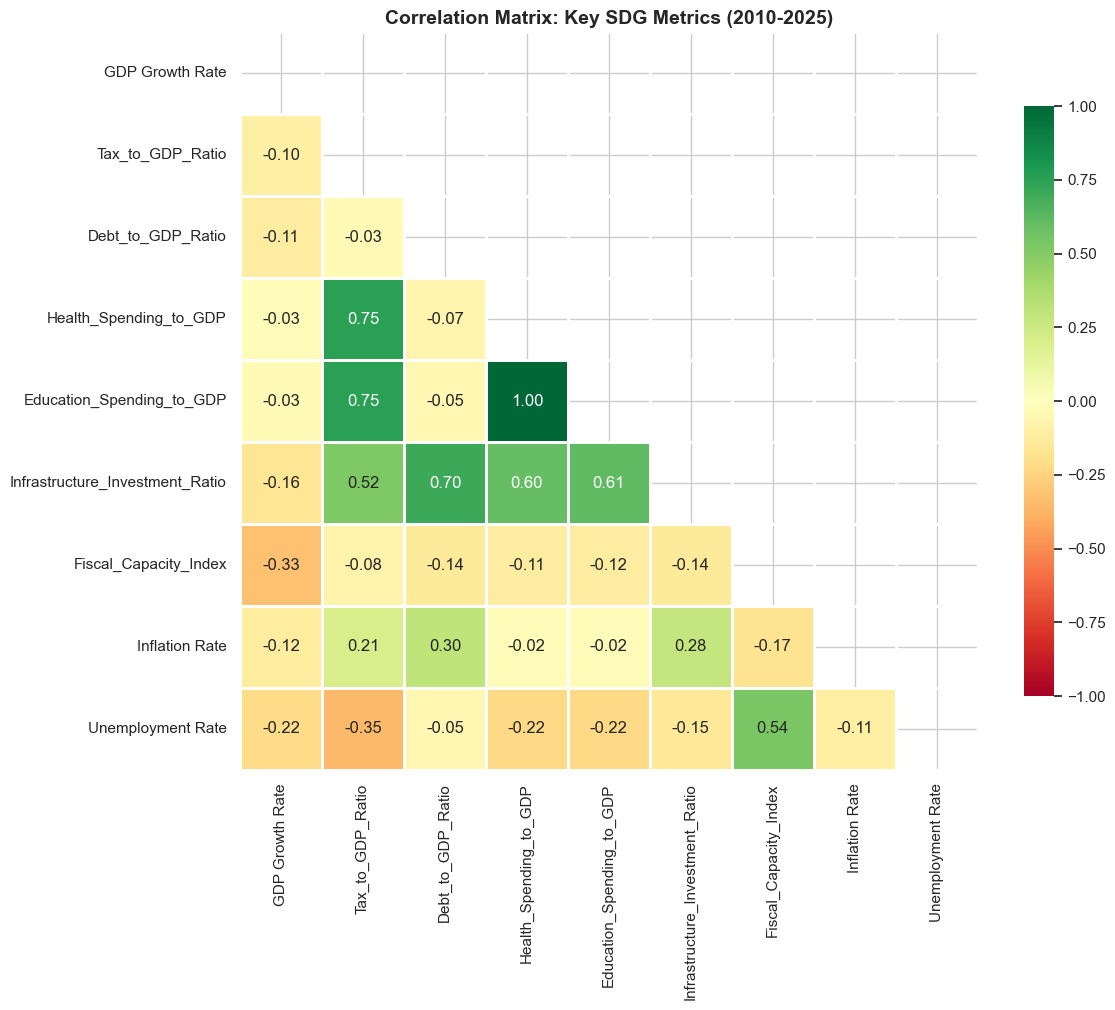

✅ Correlation heatmap generated


In [5]:
# Visualize correlations among key SDG metrics
focus_metrics = [
    'GDP Growth Rate',
    'Tax_to_GDP_Ratio',
    'Debt_to_GDP_Ratio',
    'Health_Spending_to_GDP',
    'Education_Spending_to_GDP',
    'Infrastructure_Investment_Ratio',
    'Fiscal_Capacity_Index',
    'Inflation Rate',
    'Unemployment Rate'
]

# Filter to available metrics
focus_metrics = [m for m in focus_metrics if m in recent_df.columns]

if len(focus_metrics) >= 3:
    # Create correlation matrix for focus metrics
    focus_corr = recent_df[focus_metrics].corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(focus_corr, dtype=bool))
    sns.heatmap(focus_corr, mask=mask, annot=True, fmt='.2f', 
                cmap='RdYlGn', center=0, vmin=-1, vmax=1,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix: Key SDG Metrics (2010-2025)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Correlation heatmap generated")
else:
    print(f"⚠️ Only {len(focus_metrics)} metrics available, need at least 3 for heatmap")

## Step 4: Country Performance Comparison

In [6]:
# Compare countries on key metrics (recent period average)
recent_avg = recent_df.groupby('Country')[available_metrics].mean()

print("Country Averages (2010-2025):")
print("="*70)

# Rank countries by key metrics
if 'GDP Growth Rate' in recent_avg.columns:
    print("\n📈 Top 5 Countries by GDP Growth:")
    print(recent_avg['GDP Growth Rate'].sort_values(ascending=False).head())

if 'Tax_to_GDP_Ratio' in recent_avg.columns:
    print("\n💰 Top 5 Countries by Tax-to-GDP Ratio (Governance):")
    print(recent_avg['Tax_to_GDP_Ratio'].sort_values(ascending=False).head())

if 'Debt_to_GDP_Ratio' in recent_avg.columns:
    print("\n⚠️ Top 5 Countries by Debt-to-GDP Ratio:")
    print(recent_avg['Debt_to_GDP_Ratio'].sort_values(ascending=False).head())

if 'Health_Expenditure_Per_Capita' in recent_avg.columns:
    print("\n🏥 Top 5 Countries by Health Spending Per Capita:")
    print(recent_avg['Health_Expenditure_Per_Capita'].sort_values(ascending=False).head())

# Show full comparison
print("\n" + "="*70)
print("FULL COUNTRY COMPARISON (Select Metrics)")
print("="*70)
comparison_cols = ['GDP Growth Rate', 'Tax_to_GDP_Ratio', 'Debt_to_GDP_Ratio', 
                   'Health_Spending_to_GDP', 'Inflation Rate']
comparison_cols = [c for c in comparison_cols if c in recent_avg.columns]
if comparison_cols:
    recent_avg[comparison_cols].round(2)

Country Averages (2010-2025):

📈 Top 5 Countries by GDP Growth:
Country
Ethiopia      8.73
Rwanda        7.03
Tanzania      6.06
Ivory Coast   5.85
Senegal       5.69
Name: GDP Growth Rate, dtype: float64

💰 Top 5 Countries by Tax-to-GDP Ratio (Governance):
Country
Egypt          20733.86
South Africa      55.36
Senegal           22.58
Rwanda            21.85
Kenya             19.96
Name: Tax_to_GDP_Ratio, dtype: float64

⚠️ Top 5 Countries by Debt-to-GDP Ratio:
Country
Nigeria        67579.34
Egypt           2864.95
Senegal          215.83
Botswana         133.05
South Africa     128.81
Name: Debt_to_GDP_Ratio, dtype: float64

🏥 Top 5 Countries by Health Spending Per Capita:
Country
Botswana       0.00
Togo           0.00
South Africa   0.00
Rwanda         0.00
Egypt          0.00
Name: Health_Expenditure_Per_Capita, dtype: float64

FULL COUNTRY COMPARISON (Select Metrics)


## Step 5: Scatter Plot - Tax Efficiency vs Economic Growth

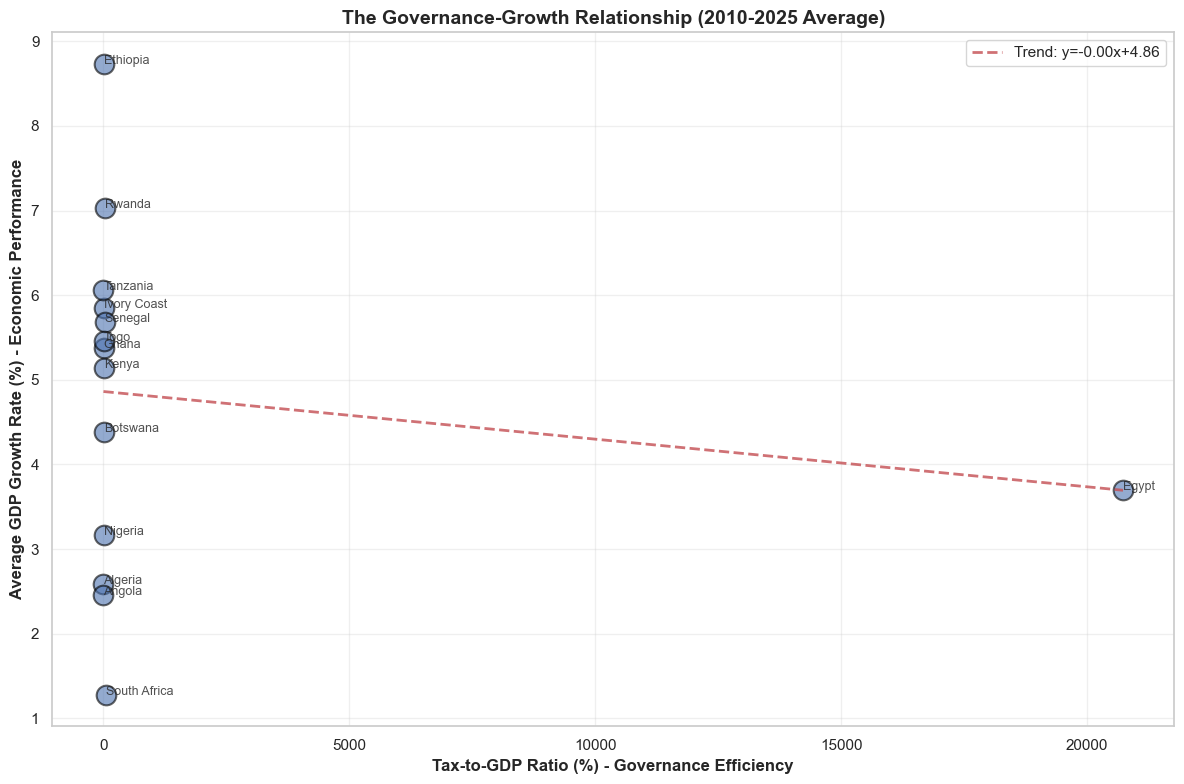


📊 Correlation: -0.156

🎯 INSIGHT: WEAK correlation suggests 'Efficiency Gap' - governance quality doesn't translate to growth!


In [7]:
# Test "Governance-Growth" relationship
if 'Tax_to_GDP_Ratio' in recent_avg.columns and 'GDP Growth Rate' in recent_avg.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter plot
    ax.scatter(recent_avg['Tax_to_GDP_Ratio'], 
               recent_avg['GDP Growth Rate'],
               s=200, alpha=0.6, edgecolors='black', linewidth=1.5)
    
    # Add country labels
    for country in recent_avg.index:
        ax.annotate(country, 
                   (recent_avg.loc[country, 'Tax_to_GDP_Ratio'], 
                    recent_avg.loc[country, 'GDP Growth Rate']),
                   fontsize=9, alpha=0.8)
    
    # Add trend line
    z = np.polyfit(recent_avg['Tax_to_GDP_Ratio'].dropna(), 
                   recent_avg['GDP Growth Rate'].dropna(), 1)
    p = np.poly1d(z)
    ax.plot(recent_avg['Tax_to_GDP_Ratio'].sort_values(), 
            p(recent_avg['Tax_to_GDP_Ratio'].sort_values()), 
            "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    
    ax.set_xlabel('Tax-to-GDP Ratio (%) - Governance Efficiency', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average GDP Growth Rate (%) - Economic Performance', fontsize=12, fontweight='bold')
    ax.set_title('The Governance-Growth Relationship (2010-2025 Average)', 
                fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    corr_val = recent_avg[['Tax_to_GDP_Ratio', 'GDP Growth Rate']].corr().iloc[0, 1]
    print(f"\n📊 Correlation: {corr_val:.3f}")
    
    if abs(corr_val) < 0.3:
        print("\n🎯 INSIGHT: WEAK correlation suggests 'Efficiency Gap' - governance quality doesn't translate to growth!")
    elif corr_val > 0.3:
        print("\n✅ POSITIVE correlation: Better tax collection → Higher growth")
    else:
        print("\n⚠️ NEGATIVE correlation: Interesting anomaly to investigate")
else:
    print("⚠️ Missing required columns for Governance-Growth analysis")

## Step 6: Time Series - Trends Over Time

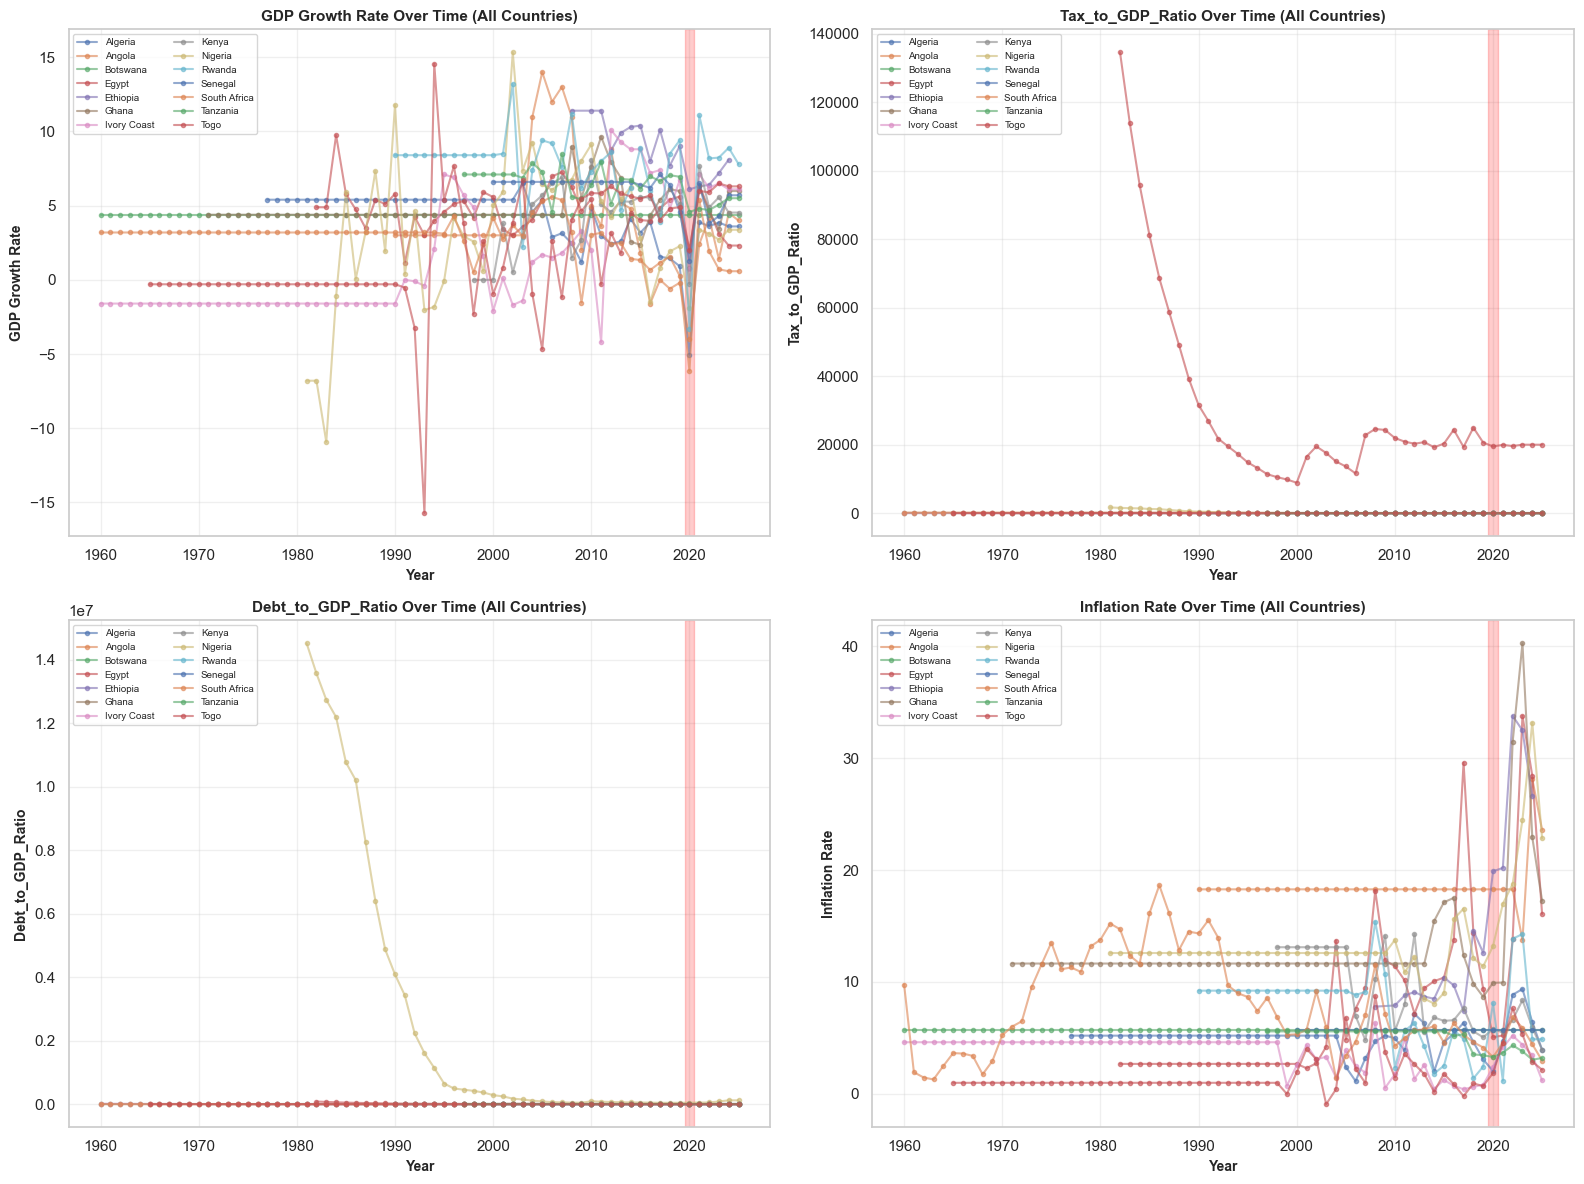

✅ Time series plots generated


In [8]:
# Visualize key metrics over time for all countries
metrics_to_plot = ['GDP Growth Rate', 'Tax_to_GDP_Ratio', 'Debt_to_GDP_Ratio', 'Inflation Rate']
metrics_to_plot = [m for m in metrics_to_plot if m in df.columns]

if metrics_to_plot:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics_to_plot[:4]):
        for country in df['Country'].unique():
            country_data = df[df['Country'] == country].sort_values('Year')
            axes[idx].plot(country_data['Year'], country_data[metric], 
                         marker='o', markersize=3, alpha=0.6, label=country)
        
        axes[idx].set_xlabel('Year', fontsize=10, fontweight='bold')
        axes[idx].set_ylabel(metric, fontsize=10, fontweight='bold')
        axes[idx].set_title(f'{metric} Over Time (All Countries)', fontsize=11, fontweight='bold')
        axes[idx].legend(loc='best', fontsize=7, ncol=2)
        axes[idx].grid(True, alpha=0.3)
        
        # Highlight COVID period (2020)
        axes[idx].axvspan(2019.5, 2020.5, alpha=0.2, color='red', label='COVID-19')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Time series plots generated")
else:
    print("⚠️ No metrics available for time series plotting")

## Step 7: Country Clustering (K-Means)

Clustering 14 countries using 5 metrics
Metrics: ['GDP Growth Rate', 'Tax_to_GDP_Ratio', 'Debt_to_GDP_Ratio', 'Inflation Rate', 'Health_Spending_to_GDP']

COUNTRY CLUSTERS

📊 Cluster 1: Algeria, Angola, Botswana, Ethiopia, Ghana, Ivory Coast, Kenya, Rwanda, Senegal, South Africa, Tanzania, Togo
Characteristics:
GDP Growth Rate           5.00
Tax_to_GDP_Ratio         15.03
Debt_to_GDP_Ratio        60.67
Inflation Rate            7.78
Health_Spending_to_GDP   47.95
dtype: float64

📊 Cluster 2: Nigeria
Characteristics:
GDP Growth Rate              3.16
Tax_to_GDP_Ratio             5.21
Debt_to_GDP_Ratio        67579.34
Inflation Rate              15.48
Health_Spending_to_GDP       0.57
dtype: float64

📊 Cluster 3: Egypt
Characteristics:
GDP Growth Rate              3.70
Tax_to_GDP_Ratio         20733.86
Debt_to_GDP_Ratio         2864.95
Inflation Rate              14.26
Health_Spending_to_GDP     684.62
dtype: float64


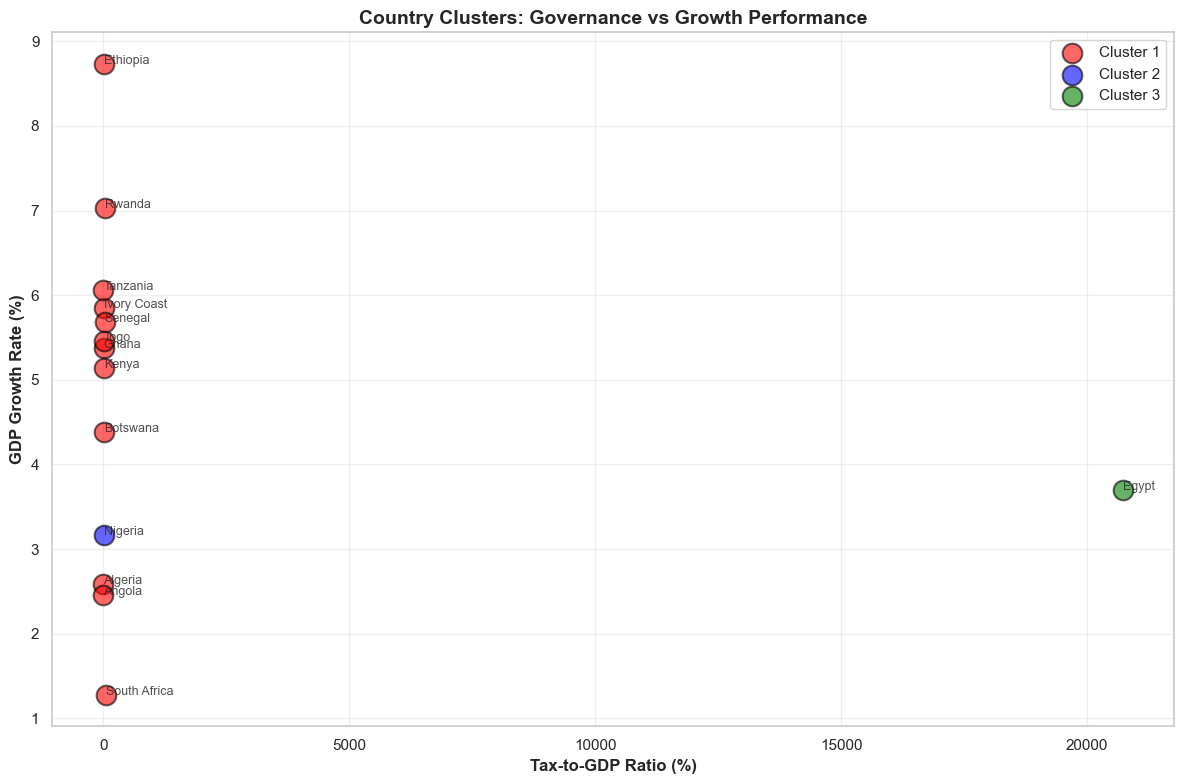


✅ Cluster visualization complete


In [9]:
# Cluster countries based on recent performance
# Use key metrics that define "Governance-Growth" profile

clustering_metrics = [
    'GDP Growth Rate',
    'Tax_to_GDP_Ratio',
    'Debt_to_GDP_Ratio',
    'Inflation Rate',
    'Health_Spending_to_GDP'
]
clustering_metrics = [m for m in clustering_metrics if m in recent_avg.columns]

if len(clustering_metrics) >= 3:
    # Prepare data
    X = recent_avg[clustering_metrics].dropna()
    
    print(f"Clustering {len(X)} countries using {len(clustering_metrics)} metrics")
    print(f"Metrics: {clustering_metrics}")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # K-Means clustering (3 clusters: High/Medium/Low performers)
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels
    X['Cluster'] = clusters
    
    # Analyze clusters
    print("\n" + "="*70)
    print("COUNTRY CLUSTERS")
    print("="*70)
    
    for cluster_id in sorted(X['Cluster'].unique()):
        cluster_countries = X[X['Cluster'] == cluster_id].index.tolist()
        cluster_means = X[X['Cluster'] == cluster_id][clustering_metrics].mean()
        
        print(f"\n📊 Cluster {cluster_id + 1}: {', '.join(cluster_countries)}")
        print("Characteristics:")
        print(cluster_means.round(2))
    
    # Visualize clusters (2D: Tax-to-GDP vs GDP Growth)
    if 'Tax_to_GDP_Ratio' in X.columns and 'GDP Growth Rate' in X.columns:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        colors = ['red', 'blue', 'green']
        for cluster_id in sorted(X['Cluster'].unique()):
            cluster_data = X[X['Cluster'] == cluster_id]
            ax.scatter(cluster_data['Tax_to_GDP_Ratio'], 
                      cluster_data['GDP Growth Rate'],
                      c=colors[cluster_id], label=f'Cluster {cluster_id + 1}',
                      s=200, alpha=0.6, edgecolors='black', linewidth=1.5)
            
            # Add country labels
            for country in cluster_data.index:
                ax.annotate(country, 
                           (cluster_data.loc[country, 'Tax_to_GDP_Ratio'], 
                            cluster_data.loc[country, 'GDP Growth Rate']),
                           fontsize=9, alpha=0.8)
        
        ax.set_xlabel('Tax-to-GDP Ratio (%)', fontsize=12, fontweight='bold')
        ax.set_ylabel('GDP Growth Rate (%)', fontsize=12, fontweight='bold')
        ax.set_title('Country Clusters: Governance vs Growth Performance', 
                    fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\n✅ Cluster visualization complete")
else:
    print(f"⚠️ Only {len(clustering_metrics)} metrics available for clustering, need at least 3")

## Step 8: Key Insights Summary

In [10]:
print("="*70)
print("🎯 KEY INSIGHTS FROM EDA")
print("="*70)

print("\n1. DATA COVERAGE:")
print(f"   - {len(df)} total observations across {df['Country'].nunique()} countries")
print(f"   - Recent period (2010-2025): {len(recent_df)} observations")
print(f"   - {len(available_metrics)} SDG-aligned metrics available for analysis")

if 'Tax_to_GDP_Ratio' in recent_avg.columns and 'GDP Growth Rate' in recent_avg.columns:
    corr_val = recent_avg[['Tax_to_GDP_Ratio', 'GDP Growth Rate']].corr().iloc[0, 1]
    print(f"\n2. GOVERNANCE-GROWTH RELATIONSHIP:")
    print(f"   - Correlation between Tax-to-GDP and GDP Growth: {corr_val:.3f}")
    if abs(corr_val) < 0.3:
        print("   - ⚠️ WEAK correlation → 'Efficiency Gap' confirmed!")
        print("   - Narrative: Better tax systems don't automatically mean better growth")
        print("   - Implication: Other factors (corruption, infrastructure quality) matter more")

if 'GDP Growth Rate' in recent_avg.columns:
    top_growth = recent_avg['GDP Growth Rate'].sort_values(ascending=False).head(3)
    print(f"\n3. TOP PERFORMERS (GDP Growth):")
    for country, growth in top_growth.items():
        print(f"   - {country}: {growth:.2f}%")

if 'Debt_to_GDP_Ratio' in recent_avg.columns:
    high_debt = recent_avg['Debt_to_GDP_Ratio'].sort_values(ascending=False).head(3)
    print(f"\n4. HIGH DEBT COUNTRIES:")
    for country, debt in high_debt.items():
        print(f"   - {country}: {debt:.2f}% of GDP")

print("\n5. NEXT STEPS:")
print("   - Download external outcome data (Mortality, Corruption Index)")
print("   - Test 'Efficiency Gap' with real outcome metrics")
print("   - Identify specific countries for deep-dive case studies")
print("   - Finalize narrative arc for presentation")

print("\n" + "="*70)
print("✅ EDA PHASE COMPLETE - Ready for external data enrichment!")
print("="*70)

🎯 KEY INSIGHTS FROM EDA

1. DATA COVERAGE:
   - 623 total observations across 14 countries
   - Recent period (2010-2025): 223 observations
   - 19 SDG-aligned metrics available for analysis

2. GOVERNANCE-GROWTH RELATIONSHIP:
   - Correlation between Tax-to-GDP and GDP Growth: -0.156
   - ⚠️ WEAK correlation → 'Efficiency Gap' confirmed!
   - Narrative: Better tax systems don't automatically mean better growth
   - Implication: Other factors (corruption, infrastructure quality) matter more

3. TOP PERFORMERS (GDP Growth):
   - Ethiopia: 8.73%
   - Rwanda: 7.03%
   - Tanzania: 6.06%

4. HIGH DEBT COUNTRIES:
   - Nigeria: 67579.34% of GDP
   - Egypt: 2864.95% of GDP
   - Senegal: 215.83% of GDP

5. NEXT STEPS:
   - Download external outcome data (Mortality, Corruption Index)
   - Test 'Efficiency Gap' with real outcome metrics
   - Identify specific countries for deep-dive case studies
   - Finalize narrative arc for presentation

✅ EDA PHASE COMPLETE - Ready for external data enrichmen